In [1]:
# Import necessary libraries and modules
import pandas as pd
import john_prepare as p
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


%load_ext autoreload
%autoreload 2

# Set the option to display all columns in DataFrames
pd.set_option('display.max_columns', None)


In [2]:
inspection_df = p.prepare_data('health_inspections.csv')
# Convert the 'inspection_date' column to datetime and format it to display only the date (YYYY-MM-DD)
inspection_df['inspection_date'] = pd.to_datetime(inspection_df['inspection_date'])

inspection_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150959 entries, 0 to 204565
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   camis                  150959 non-null  int64         
 1   dba                    150959 non-null  object        
 2   boro                   150959 non-null  object        
 3   building               150959 non-null  object        
 4   street                 150959 non-null  object        
 5   zipcode                150959 non-null  object        
 6   phone                  150959 non-null  object        
 7   inspection_date        150959 non-null  datetime64[ns]
 8   critical_flag          150959 non-null  object        
 9   record_date            150959 non-null  object        
 10  latitude               150959 non-null  float64       
 11  longitude              150959 non-null  float64       
 12  community_board        150959 non-null  object   

In [3]:
violation_df = pd.read_csv('ViolationData.csv')
violation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   violation_code     263 non-null    object
 1   violation_summary  263 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


In [4]:
# Remove duplicates from violation_df based on 'violation_code'
violation_df.drop_duplicates(subset='violation_code', inplace=True)

# Add a new column 'violation_summary' to inspection_df based on matching violation_code using violation_df
inspection_df['violation_summary'] = inspection_df['violation_code'].map(violation_df.set_index('violation_code')['violation_summary'])
inspection_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150959 entries, 0 to 204565
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   camis                  150959 non-null  int64         
 1   dba                    150959 non-null  object        
 2   boro                   150959 non-null  object        
 3   building               150959 non-null  object        
 4   street                 150959 non-null  object        
 5   zipcode                150959 non-null  object        
 6   phone                  150959 non-null  object        
 7   inspection_date        150959 non-null  datetime64[ns]
 8   critical_flag          150959 non-null  object        
 9   record_date            150959 non-null  object        
 10  latitude               150959 non-null  float64       
 11  longitude              150959 non-null  float64       
 12  community_board        150959 non-null  object   

In [5]:
inspection_df.violation_code.nunique()

73

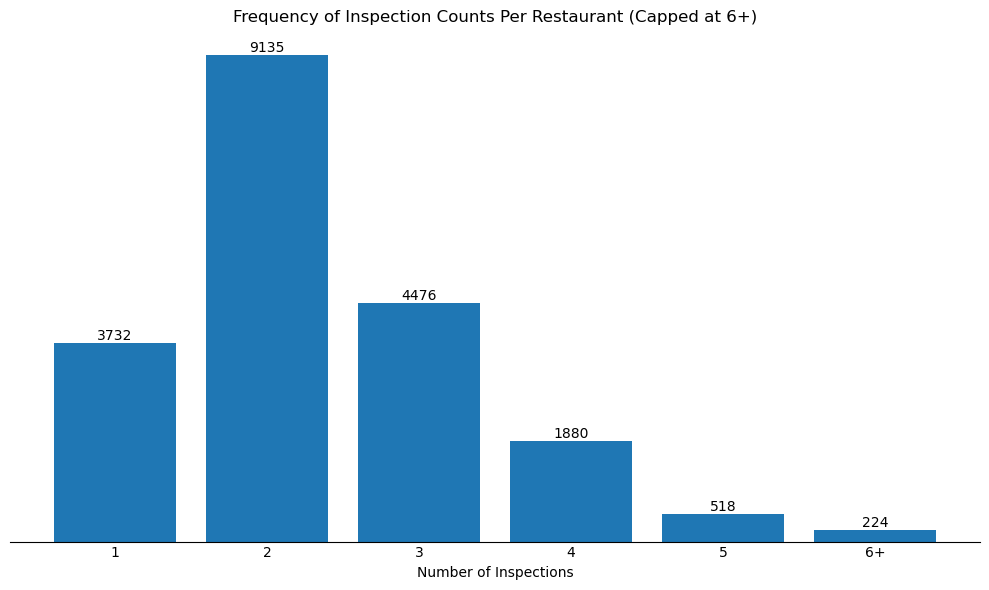

In [20]:
# Remove duplicates to ensure each row is a unique inspection
unique_inspections_df = inspection_df.drop_duplicates(subset=['camis', 'inspection_date'])

# Calculate the number of inspections per restaurant
inspections_per_restaurant = unique_inspections_df.groupby('camis').size()

# Cap the values at 8+ for restaurants with 8 or more inspections
inspections_per_restaurant_capped = inspections_per_restaurant.apply(lambda x: '6+' if x >= 6 else x)

# Convert all indices to string to avoid TypeError during sorting
inspections_per_restaurant_capped = inspections_per_restaurant_capped.astype(str)

# Get the value counts of inspections per restaurant and convert indices to strings
inspection_counts = inspections_per_restaurant_capped.value_counts().sort_index(key=lambda x: x.astype(str))

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(inspection_counts.index, inspection_counts.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xlabel('Number of Inspections')

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
            ha='center', va='bottom')

plt.title('Frequency of Inspection Counts Per Restaurant (Capped at 6+)')
plt.tight_layout()
plt.show()

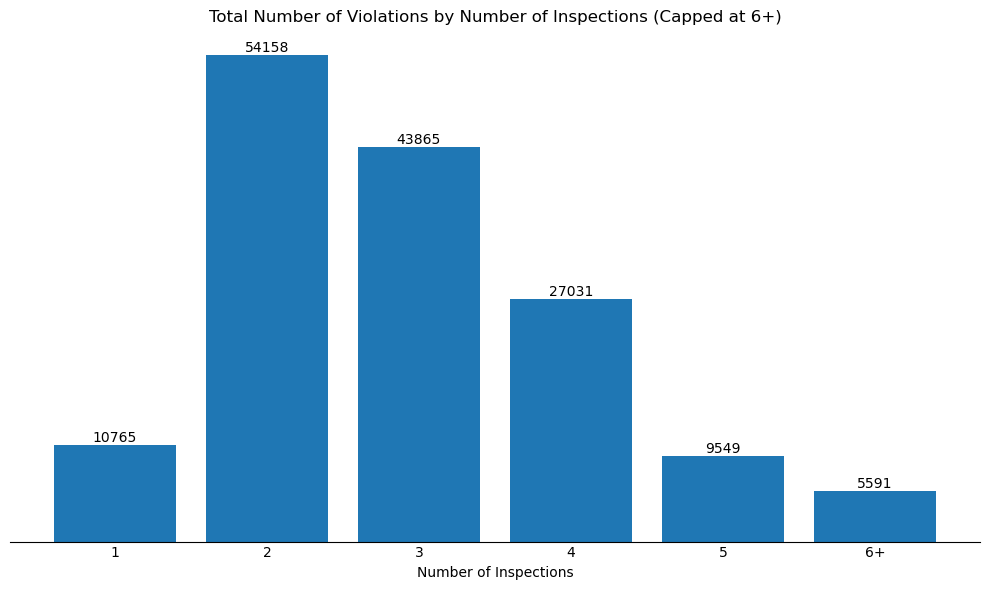

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Calculate the number of inspections per restaurant
inspections_per_restaurant = inspection_df.groupby('camis')['inspection_date'].nunique()

# Capping the inspection counts at 6+
inspections_per_restaurant_capped = inspections_per_restaurant.apply(lambda x: '6+' if x >= 6 else x).astype(str)

# Count the total violations for each restaurant
# Assuming each row in inspection_df is a violation
violations_per_restaurant = inspection_df.groupby('camis').size()

# Grouping the total violations by the capped inspection count
violations_by_inspection_count = violations_per_restaurant.groupby(inspections_per_restaurant_capped).sum()

# Sorting the index to ensure '6+' appears last
violations_by_inspection_count = violations_by_inspection_count.reindex(list(map(str, range(1, 6))) + ['6+'])

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(violations_by_inspection_count.index, violations_by_inspection_count.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xlabel('Number of Inspections')
plt.ylabel('Number of Violations')

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
            ha='center', va='bottom')

plt.title('Total Number of Violations by Number of Inspections (Capped at 6+)')
plt.tight_layout()
plt.show()


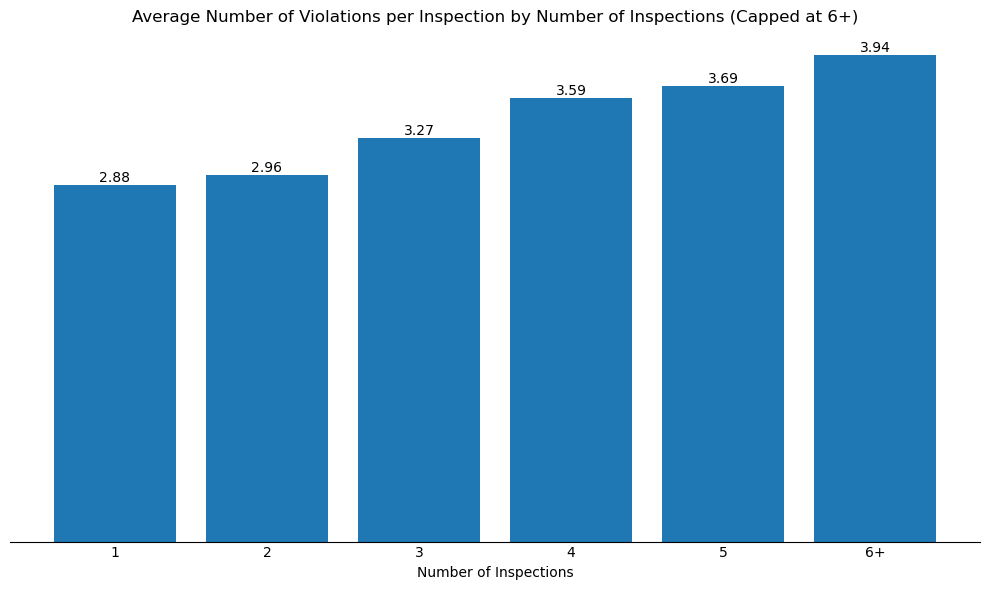

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Calculate the number of inspections per restaurant
inspections_per_restaurant = inspection_df.groupby('camis')['inspection_date'].nunique()

# Calculate the total violations for each restaurant
violations_per_restaurant = inspection_df.groupby('camis').size()

# Combine the inspections and violations data
combined_data = pd.DataFrame({
    'inspections': inspections_per_restaurant,
    'violations': violations_per_restaurant
})

# Calculate the average number of violations per inspection for each restaurant
combined_data['average_violations'] = combined_data['violations'] / combined_data['inspections']

# Group by the number of inspections and calculate the mean average violations per inspection
grouped_data = combined_data.groupby('inspections')['average_violations'].mean()

# Bin the data, with '6+' representing restaurants with 6 or more inspections
bins = list(range(1, 6)) + ['6+']
binned_data = grouped_data.reindex(range(1, 6)).fillna(0)
binned_data.index = binned_data.index.astype(str)
binned_data.at['6+'] = grouped_data.loc[6:].mean()

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(binned_data.index, binned_data.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xlabel('Number of Inspections')
plt.ylabel('Average Violations per Inspection')

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
            ha='center', va='bottom')

plt.title('Average Number of Violations per Inspection by Number of Inspections (Capped at 6+)')
plt.tight_layout()
plt.show()


C:\Users\Steel\AppData\Local\Temp\ipykernel_3428\2019247390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inspection_year'] = pd.to_datetime(df['inspection_date']).dt.year


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

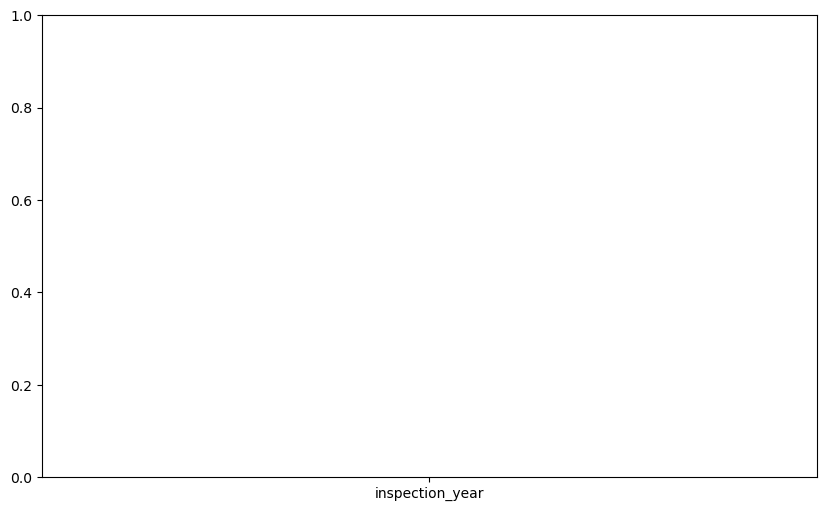

In [5]:
import matplotlib.pyplot as plt

# Create a new dataframe with 'camis', 'inspection_year', and 'score' columns
df = inspection_df[['camis', 'inspection_date', 'score']]
df['inspection_year'] = pd.to_datetime(df['inspection_date']).dt.year
df = df[['camis', 'inspection_year', 'score']].groupby(['camis','inspection_year'])['score'].mean().reset_index()

# Create a new dataframe for the average scores per inspection number
avg_scores = pd.DataFrame(df.groupby('camis')['score'].apply(lambda x: x.rolling(len(x), min_periods=1).mean()))
avg_scores.reset_index(level=0, inplace=True)
avg_scores = avg_scores.rename(columns={'camis': 'Camis ID', 'score': 'Average Score'})

# Plotting the average scores per inspection number for each group of restaurants
plt.figure(figsize=(10,6))
for camis in avg_scores['Camis ID'].unique():
    plt.plot('inspection_year', 'Average Score', data=avg_scores[avg_scores['Camis ID'] == camis], label=camis)
plt.xlabel('Inspection Year')
plt.ylabel('Average Violation Score')
plt.title('Change in Health Code Violations Over Time for Restaurants (Grouped by Total Inspections)')
plt.legend(loc='upper right', title="Camis ID")  # Add a legend to distinguish between different restaurants
plt.grid(True)
plt.show()

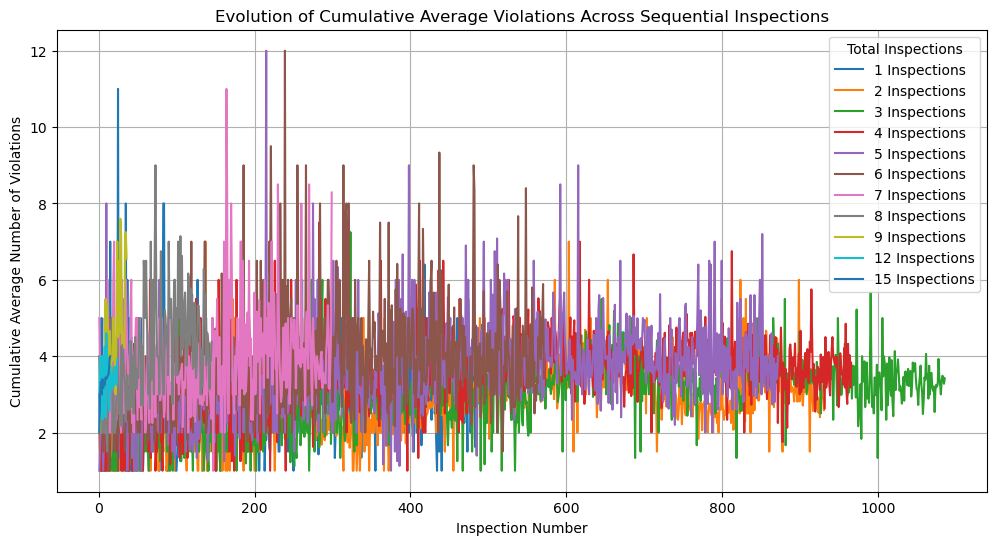

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Count violations per inspection
violations_per_inspection = inspection_df.groupby(['camis', 'inspection_date']).size().reset_index(name='violations')

# Calculate the inspection number for each inspection
violations_per_inspection['inspection_number'] = violations_per_inspection.groupby('camis').cumcount() + 1

# Calculate total number of inspections per restaurant
total_inspections = violations_per_inspection.groupby('camis')['inspection_date'].nunique()

# Add total inspections to the dataframe
violations_per_inspection = violations_per_inspection.join(total_inspections, on='camis', rsuffix='_total')

# Group by total inspections and inspection number and calculate average violations
avg_violations_per_inspection = violations_per_inspection.groupby(['inspection_date_total', 'inspection_number'])['violations'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for total_inspections in avg_violations_per_inspection['inspection_date_total'].unique():
    # Filter data for each total inspections group
    group_data = avg_violations_per_inspection[avg_violations_per_inspection['inspection_date_total'] == total_inspections]
    plt.plot(group_data['inspection_number'], group_data['violations'], label=f'{total_inspections} Total Inspections')

# Customize the plot
plt.xlabel('Inspection Number')
plt.ylabel('Average Number of Violations')
plt.title('Average Violations Per Inspection Across Different Total Inspection Counts')
plt.legend(title='Total Inspections')
plt.grid(True)

plt.show()


ValueError: x and y must have same first dimension, but have shapes (1,) and (493, 2)

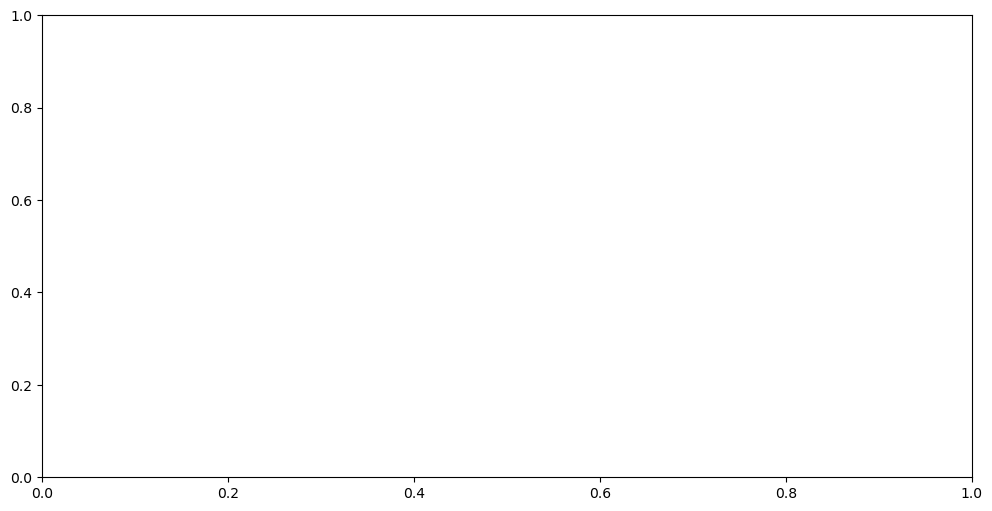

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Calculate the number of inspections and violations per restaurant and per inspection
violations_per_inspection = inspection_df.groupby(['camis', 'inspection_date']).size()

# Calculate cumulative average violations for each inspection per restaurant
cumulative_avg_violations = violations_per_inspection.groupby(level=0).cumsum() / violations_per_inspection.groupby(level=0).cumcount().add(1)

# Reset index and add total inspections per restaurant
cumulative_avg_violations = cumulative_avg_violations.reset_index()
cumulative_avg_violations['total_inspections'] = cumulative_avg_violations.groupby('camis')['inspection_date'].transform('count')

# Group by total inspections and inspection number, then calculate mean average violations
grouped = cumulative_avg_violations.groupby(['total_inspections', 'inspection_date']).mean()

# Prepare the plot
plt.figure(figsize=(12, 6))

# Plot each group as a separate line
for total_inspections in grouped.index.get_level_values(0).unique():
    data = grouped.xs(total_inspections, level='total_inspections')
    plt.plot(range(1, total_inspections + 1), data, label=f'{total_inspections} Inspections')

# Customize the plot
plt.xlabel('Inspection Number')
plt.ylabel('Cumulative Average Number of Violations')
plt.title('Evolution of Cumulative Average Violations Across Sequential Inspections')
plt.legend(title='Total Inspections')
plt.grid(True)

plt.show()


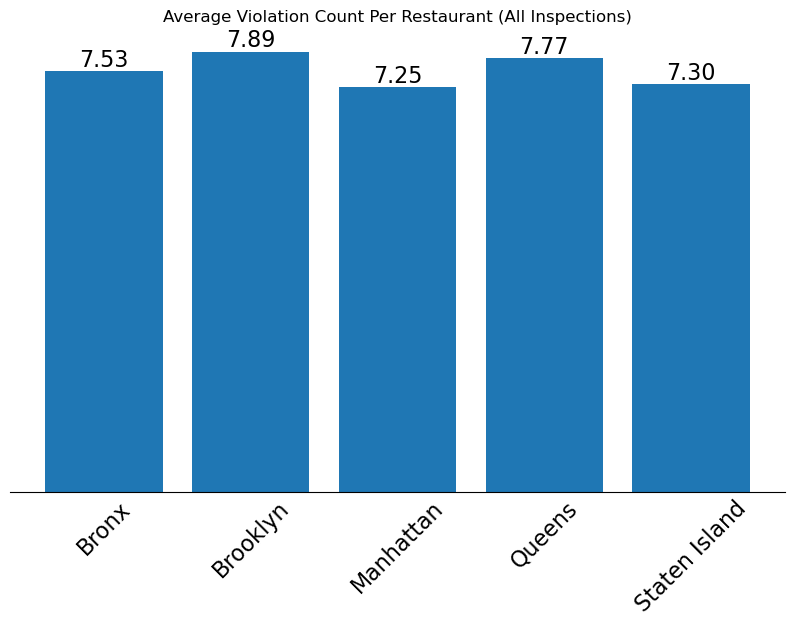

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the number of restaurants in each borough
num_restaurants_per_boro = inspection_df.groupby('boro')['camis'].nunique()

# Step 2: Calculate the total number of violations in each borough
total_violations_per_boro = inspection_df.groupby('boro').size()

# Step 3: Normalize the violation counts
normalized_violations = total_violations_per_boro / num_restaurants_per_boro

# Step 4: Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(normalized_violations.index, normalized_violations.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
            ha='center', va='bottom', fontsize=16)

plt.title('Average Violation Count Per Restaurant (All Inspections)')
plt.show()


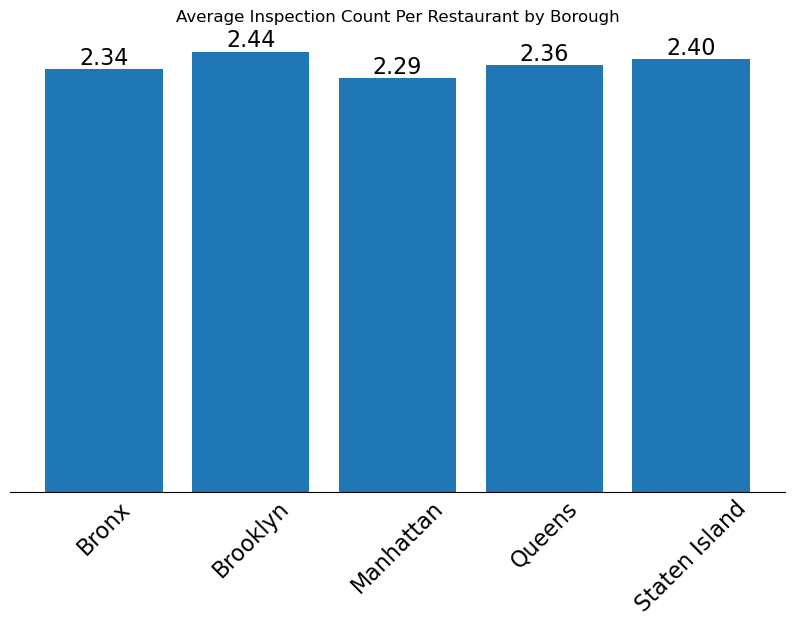

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Remove duplicates to ensure each row is a unique inspection
unique_inspections_df = inspection_df.drop_duplicates(subset=['camis', 'inspection_date'])

# Step 1: Calculate the number of restaurants in each borough
num_restaurants_per_boro = unique_inspections_df.groupby('boro')['camis'].nunique()

# Step 2: Calculate the total number of unique inspections in each borough
total_inspections_per_boro = unique_inspections_df.groupby('boro').size()

# Step 3: Normalize the inspection counts to get the average inspections per restaurant
average_inspections_per_restaurant = total_inspections_per_boro / num_restaurants_per_boro

# Step 4: Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(average_inspections_per_restaurant.index, average_inspections_per_restaurant.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
            ha='center', va='bottom', fontsize=16)

plt.title('Average Inspection Count Per Restaurant by Borough')
plt.show()


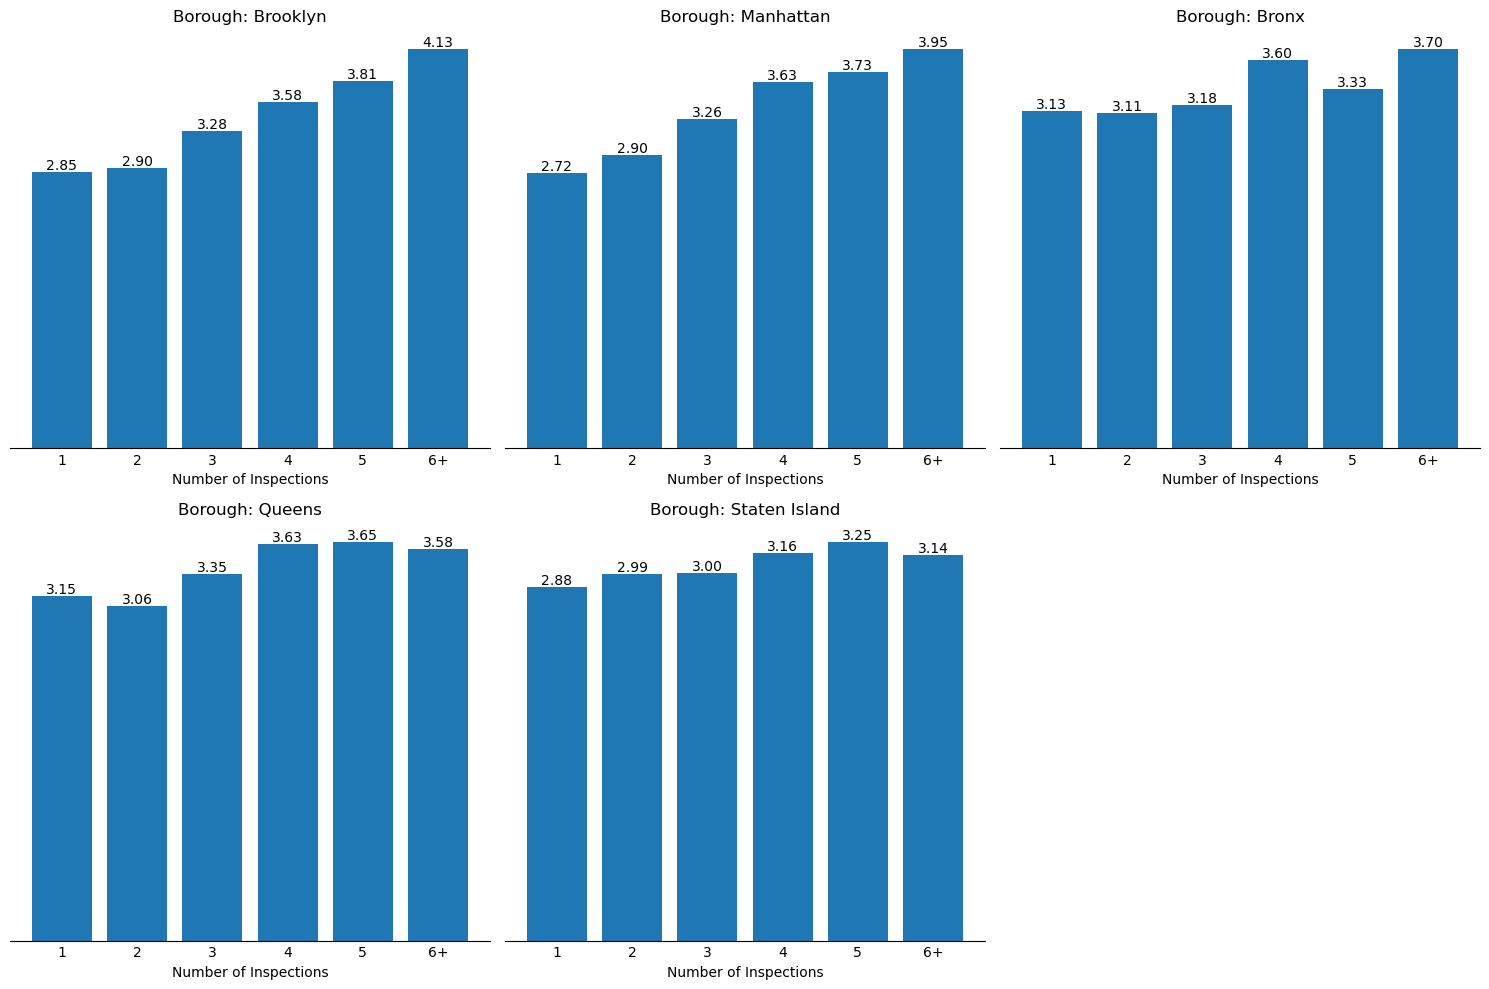

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Define the list of boroughs to consider
boroughs = inspection_df['boro'].unique()

# Create the figure for subplots in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each borough and create a subplot
for i, boro in enumerate(boroughs):
    # Filter data for the current borough
    borough_data = inspection_df[inspection_df['boro'] == boro]
    
    # Calculate the number of inspections and violations per restaurant in the borough
    inspections_per_restaurant = borough_data.groupby('camis')['inspection_date'].nunique()
    violations_per_restaurant = borough_data.groupby('camis').size()

    # Combine and calculate average violations
    combined_data = pd.DataFrame({'inspections': inspections_per_restaurant, 'violations': violations_per_restaurant})
    combined_data['average_violations'] = combined_data['violations'] / combined_data['inspections']

    # Group by inspection count and calculate mean average violations
    grouped_data = combined_data.groupby('inspections')['average_violations'].mean()

    # Bin the data with '6+' for 6 or more inspections
    binned_data = grouped_data.reindex(range(1, 6)).fillna(0)
    binned_data.index = binned_data.index.astype(str)
    binned_data.at['6+'] = grouped_data.loc[6:].mean()

    # Plot for the borough
    ax = axes[i]
    bars = ax.bar(binned_data.index, binned_data.values)

    # Customize the plot
    ax.set_title(f'Borough: {boro}')
    ax.set_xlabel('Number of Inspections')
    ax.set_ylabel('Average Violations per Inspection')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis='x', length=0)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Hide the unused subplot (the last one in the grid)
axes[len(boroughs)].axis('off')

plt.tight_layout()
plt.show()


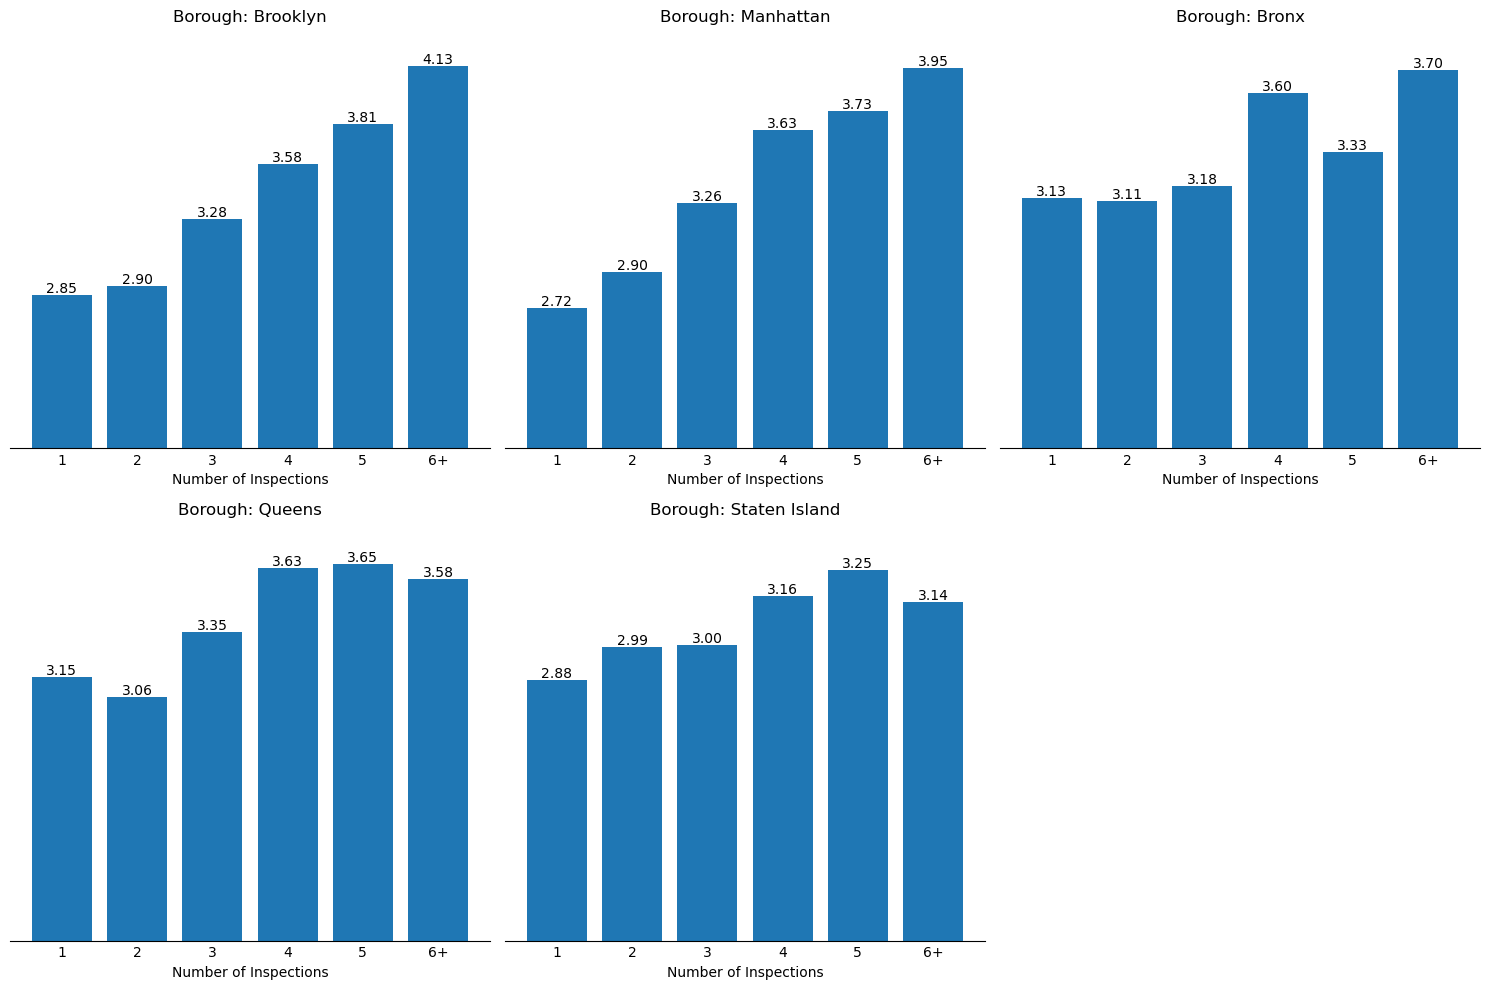

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Define the list of boroughs to consider
boroughs = inspection_df['boro'].unique()

# Create the figure for subplots in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each borough and create a subplot
for i, boro in enumerate(boroughs):
    # Filter data for the current borough
    borough_data = inspection_df[inspection_df['boro'] == boro]
    
    # Calculate the number of inspections and violations per restaurant in the borough
    inspections_per_restaurant = borough_data.groupby('camis')['inspection_date'].nunique()
    violations_per_restaurant = borough_data.groupby('camis').size()

    # Combine and calculate average violations
    combined_data = pd.DataFrame({'inspections': inspections_per_restaurant, 'violations': violations_per_restaurant})
    combined_data['average_violations'] = combined_data['violations'] / combined_data['inspections']

    # Group by inspection count and calculate mean average violations
    grouped_data = combined_data.groupby('inspections')['average_violations'].mean()

    # Bin the data with '6+' for 6 or more inspections
    binned_data = grouped_data.reindex(range(1, 6)).fillna(0)
    binned_data.index = binned_data.index.astype(str)
    binned_data.at['6+'] = grouped_data.loc[6:].mean()

    # Plot for the borough
    ax = axes[i]
    bars = ax.bar(binned_data.index, binned_data.values)

    # Customize the plot
    ax.set_title(f'Borough: {boro}')
    ax.set_xlabel('Number of Inspections')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis='x', length=0)
    ax.set_ylim([2, ax.get_ylim()[1]])  # Set the starting point of y-axis to 2

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Hide the unused subplot (the last one in the grid)
axes[len(boroughs)].axis('off')

plt.tight_layout()
plt.show()


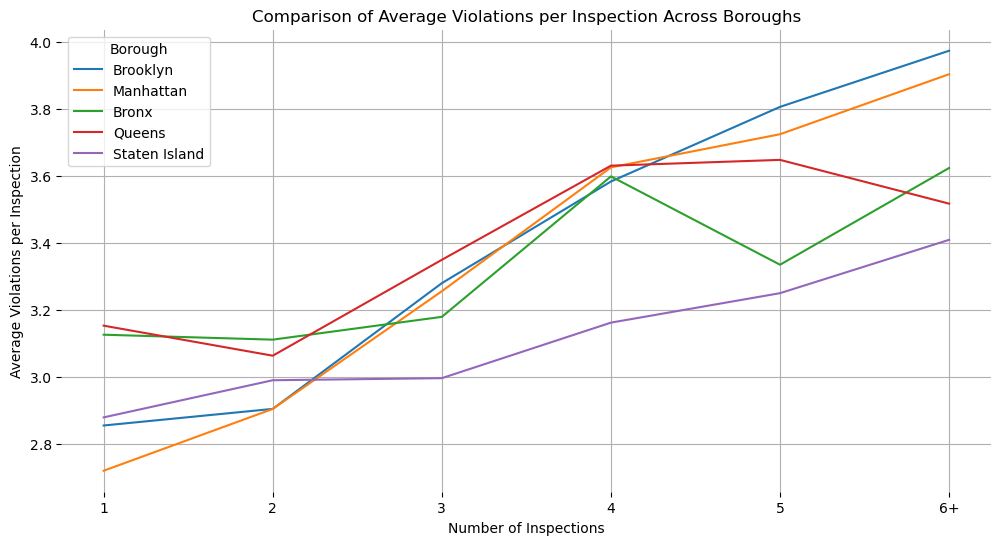

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Define the list of boroughs to consider
boroughs = inspection_df['boro'].unique()

# Prepare a list for storing aggregated data for each borough
borough_data_list = []

# Function to categorize inspections count
def categorize_inspections(x):
    return '6+' if x >= 6 else str(x)

# Loop through each borough to aggregate data
for boro in boroughs:
    # Filter data for the current borough
    borough_data = inspection_df[inspection_df['boro'] == boro]
    
    # Calculate the number of inspections per restaurant
    inspections_per_restaurant = borough_data.groupby('camis')['inspection_date'].nunique()
    inspections_per_restaurant_categorized = inspections_per_restaurant.apply(categorize_inspections)

    # Count the total violations per restaurant
    violations_per_restaurant = borough_data.groupby('camis').size()

    # Combine the inspections and violations data
    combined_data = pd.DataFrame({'inspections': inspections_per_restaurant_categorized, 'violations': violations_per_restaurant})
    combined_data['average_violations'] = combined_data['violations'] / inspections_per_restaurant
    combined_data['boro'] = boro

    # Group by inspection count and calculate mean average violations
    grouped_data = combined_data.groupby('inspections')['average_violations'].mean().reset_index()
    grouped_data['boro'] = boro

    # Append to the list
    borough_data_list.append(grouped_data)

# Concatenate all borough data
borough_aggregated_data = pd.concat(borough_data_list)

# Create a line graph
plt.figure(figsize=(12, 6))
for boro in boroughs:
    borough_data = borough_aggregated_data[borough_aggregated_data['boro'] == boro]
    plt.plot(borough_data['inspections'], borough_data['average_violations'], label=boro)

# Customize the plot
plt.xlabel('Number of Inspections')
plt.ylabel('Average Violations per Inspection')
plt.title('Comparison of Average Violations per Inspection Across Boroughs')
plt.legend(title='Borough')
plt.grid(True)

# Remove the box (spines) around the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()


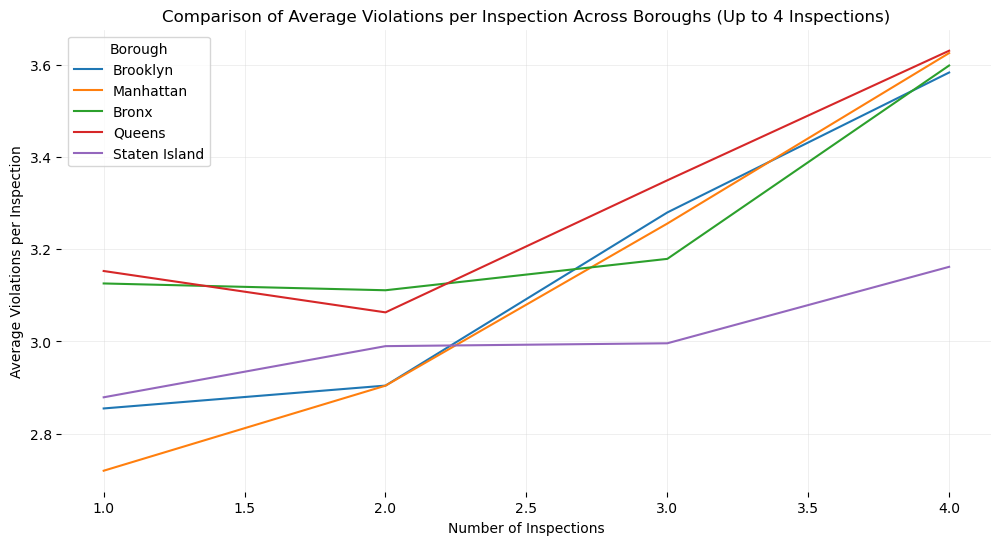

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming inspection_df is your DataFrame with the NYC health inspections data

# Define the list of boroughs to consider
boroughs = inspection_df['boro'].unique()

# Prepare a list for storing aggregated data for each borough
borough_data_list = []

# Loop through each borough to aggregate data
for boro in boroughs:
    # Filter data for the current borough
    borough_data = inspection_df[inspection_df['boro'] == boro]
    
    # Calculate the number of inspections per restaurant
    inspections_per_restaurant = borough_data.groupby('camis')['inspection_date'].nunique()

    # Filter out restaurants with more than 4 inspections
    filtered_data = borough_data[borough_data['camis'].isin(inspections_per_restaurant[inspections_per_restaurant <= 4].index)]

    # Count the total violations per restaurant
    violations_per_restaurant = filtered_data.groupby('camis').size()

    # Calculate the average number of violations per inspection
    combined_data = pd.DataFrame({'inspections': inspections_per_restaurant, 'violations': violations_per_restaurant})
    combined_data['average_violations'] = combined_data['violations'] / combined_data['inspections']
    combined_data['boro'] = boro

    # Group by inspection count and calculate mean average violations
    grouped_data = combined_data.groupby('inspections')['average_violations'].mean().reset_index()
    grouped_data['boro'] = boro

    # Append to the list
    borough_data_list.append(grouped_data)

# Concatenate all borough data
borough_aggregated_data = pd.concat(borough_data_list)

# Create a line graph
plt.figure(figsize=(12, 6))
for boro in boroughs:
    borough_data = borough_aggregated_data[borough_aggregated_data['boro'] == boro]
    plt.plot(borough_data['inspections'], borough_data['average_violations'], label=boro)

# Customize the plot
plt.xlabel('Number of Inspections')
plt.ylabel('Average Violations per Inspection')
plt.title('Comparison of Average Violations per Inspection Across Boroughs (Up to 4 Inspections)')
plt.legend(title='Borough')

# Customize grid lines to be less noticeable
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
# Remove the box (spines) around the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()


In [191]:
num_restaurants_per_boro

boro
Bronx            1830
Brooklyn         5207
Manhattan        7663
Queens           4517
Staten Island     748
Name: camis, dtype: int64

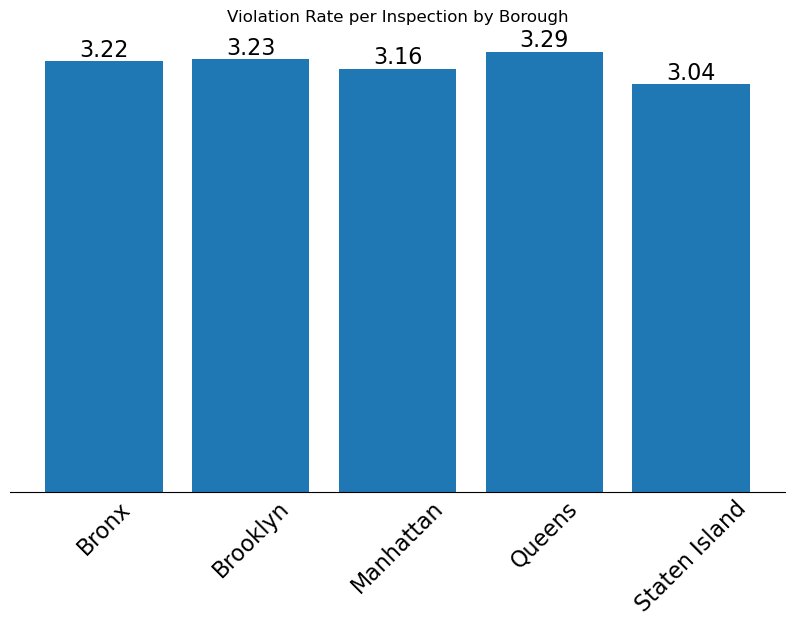

In [192]:
# Step 1: Calculate the total number of violations per borough
total_violations_per_boro = inspection_df.groupby('boro').size()

# Step 2: Calculate the total number of unique inspections per borough
# Each unique combination of camis and inspection_date represents a unique inspection
total_inspections_per_boro = inspection_df.groupby('boro').apply(lambda x: x.drop_duplicates(['camis', 'inspection_date']).shape[0])

# Step 3: Calculate Violation Rate per Inspection
violation_rate_per_inspection = total_violations_per_boro / total_inspections_per_boro

# Step 4: Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(violation_rate_per_inspection.index, violation_rate_per_inspection.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
            ha='center', va='bottom', fontsize=16)

plt.title('Violation Rate per Inspection by Borough')
plt.show()


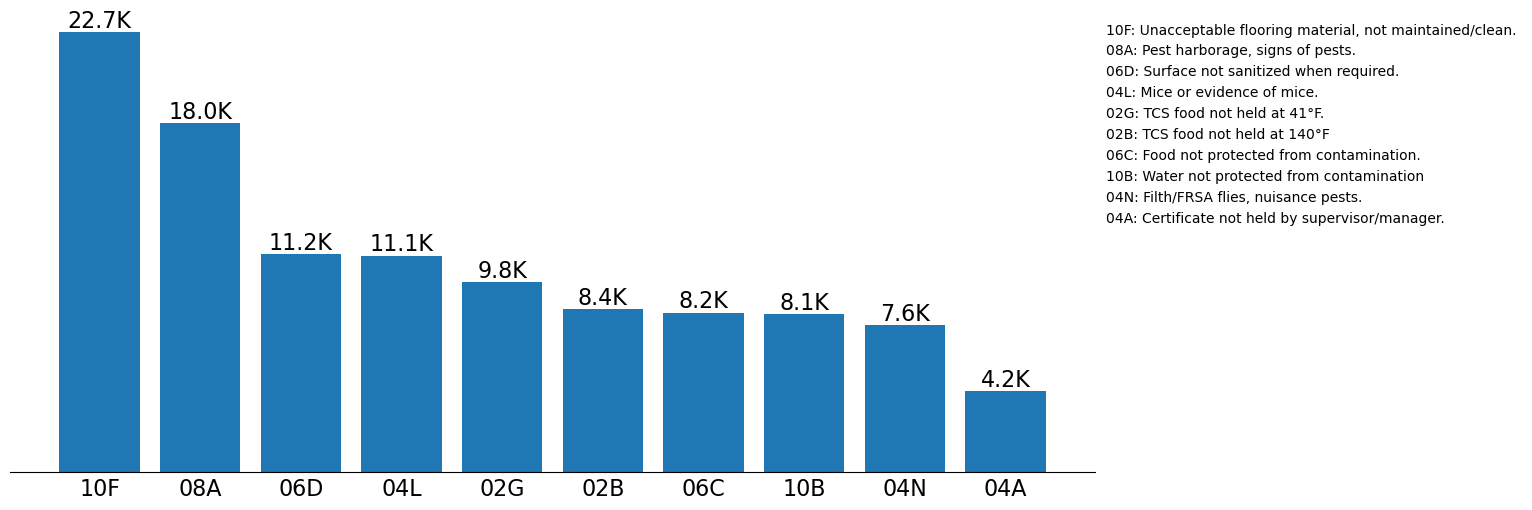

In [ ]:
# Counting top 10 violations
violation_counts = inspection_df['violation_code'].value_counts().head(10)

# Creating the plot
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(violation_counts.index, violation_counts.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=0, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    if height > 1000:
        text_label = f'{height / 1000:.1f}K'
    else:
        text_label = str(int(round(height / 10) * 10))
    
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, text_label,
            ha='center', va='bottom', fontsize=16)

# Creating a custom legend
# Create a dictionary mapping violation codes to summaries
violation_summary_dict = inspection_df.drop_duplicates('violation_code').set_index('violation_code')['violation_summary'].to_dict()
legend_patches = [mpatches.Patch(color='none', label=f'{code}: {violation_summary_dict[code]}') for code in violation_counts.index]
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)

plt.show()


In [194]:
inspection_df.inspection_type.unique()

array(['Cycle Inspection / Reopening Inspection',
       'Cycle Inspection / Re-inspection',
       'Cycle Inspection / Initial Inspection',
       'Inter-Agency Task Force / Initial Inspection',
       'Cycle Inspection / Compliance Inspection',
       'Cycle Inspection / Second Compliance Inspection',
       'Inter-Agency Task Force / Re-inspection'], dtype=object)

In [195]:
# Count inspections by unique values in the 'inspection_type' column
inspection_counts_by_type = inspection_df['inspection_type'].value_counts()
inspection_counts_by_type, inspection_counts_by_type.sum()

(inspection_type
 Cycle Inspection / Initial Inspection              111939
 Cycle Inspection / Re-inspection                    36479
 Cycle Inspection / Reopening Inspection              1379
 Cycle Inspection / Compliance Inspection              821
 Inter-Agency Task Force / Initial Inspection          300
 Cycle Inspection / Second Compliance Inspection        40
 Inter-Agency Task Force / Re-inspection                 1
 Name: count, dtype: int64,
 150959)

In [196]:
# Then we count the inspections by inspection_type
unique_inspections = inspection_df.drop_duplicates(subset=['camis', 'inspection_date'])
inspection_counts_by_type = unique_inspections['inspection_type'].value_counts()
inspection_counts_by_type


inspection_type
Cycle Inspection / Initial Inspection              34248
Cycle Inspection / Re-inspection                   11613
Cycle Inspection / Reopening Inspection              754
Cycle Inspection / Compliance Inspection             230
Inter-Agency Task Force / Initial Inspection         149
Cycle Inspection / Second Compliance Inspection       13
Inter-Agency Task Force / Re-inspection                1
Name: count, dtype: int64

C:\Users\Steel\AppData\Local\Temp\ipykernel_21592\1013532251.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


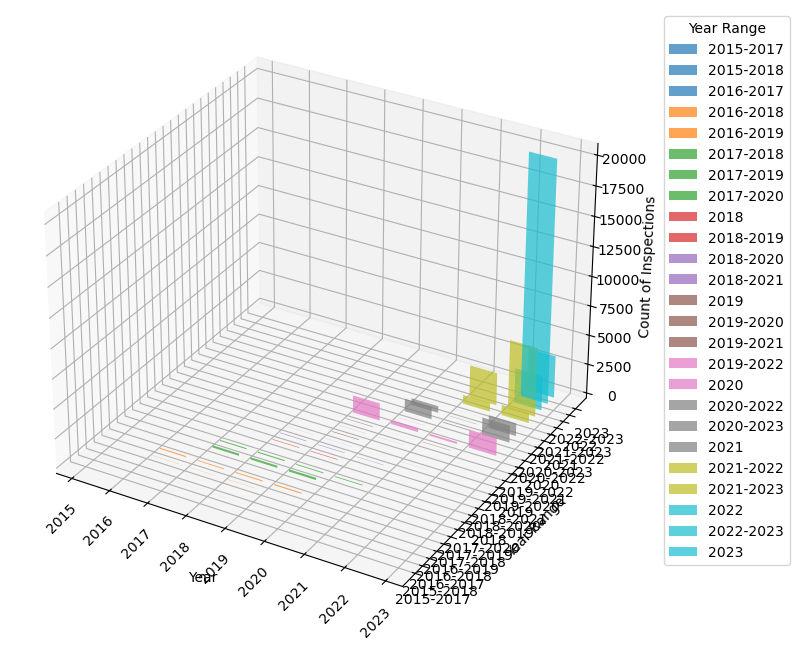

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming 'inspection_df' is your original DataFrame
# Step 1: Create a copy of the DataFrame with selected columns
inspections_df_copy = inspection_df[['camis', 'inspection_date']].copy()

# Step 2: Remove duplicate rows based on 'camis' and 'inspection_date'
inspections_df_copy.drop_duplicates(subset=['camis', 'inspection_date'], inplace=True)

# Step 3: Group by 'camis' and aggregate the minimum and maximum years
year_range_df = inspections_df_copy.groupby('camis')['inspection_date'].agg(['min', 'max'])
year_range_df['min'] = year_range_df['min'].dt.year
year_range_df['max'] = year_range_df['max'].dt.year

# Format the 'year_range' column
year_range_df['year_range'] = year_range_df.apply(lambda x: f"{x['min']}-{x['max']}" if x['min'] != x['max'] else f"{x['min']}", axis=1)

# Step 4: Merge the year range back to the original DataFrame
inspections_df_copy = inspections_df_copy.merge(year_range_df['year_range'], on='camis', how='left')

# Step 5: Extract year and create 'year' column
inspections_df_copy['year'] = inspections_df_copy['inspection_date'].dt.year

# Step 6: Drop the 'inspection_date' column
inspections_df_copy.drop(columns=['inspection_date'], inplace=True)

# Sort the DataFrame by 'year'
inspections_df_copy.sort_values('year', inplace=True)

# Get the unique year ranges and years, sorted for consistent plotting
unique_year_ranges = inspections_df_copy['year_range'].unique()
unique_year_ranges.sort()
unique_years = np.arange(inspections_df_copy['year'].min(), inspections_df_copy['year'].max() + 1)

# Create a color map
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_year_ranges)))

# Creating the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot a bar for each year range
for yr_index, year_range in enumerate(unique_year_ranges):
    # Filter the data for each year_range
    subset = inspections_df_copy[inspections_df_copy['year_range'] == year_range]
    hist, bins = np.histogram(subset['year'], bins=unique_years)
    
    # Center the bins
    xs = (bins[:-1] + bins[1:]) / 2

    # Plot the histogram bars for each year range at the correct y position
    ax.bar(xs, hist, zs=yr_index, zdir='y', alpha=0.7, color=colors[yr_index], label=year_range, width=0.7)

# Customization
ax.set_xlabel('Year')
ax.set_ylabel('Year Range')
ax.set_zlabel('Count of Inspections')
ax.set_yticks(range(len(unique_year_ranges)))
ax.set_yticklabels(unique_year_ranges)
ax.set_xticks(unique_years)
ax.set_xticklabels(unique_years, rotation=45)
ax.legend(title="Year Range", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


In [240]:
inspections_df_copy

,camis,year_range,year
7835,40944945,2015-2018,2015
16086,41611709,2015-2017,2015
19414,40560949,2015-2018,2015
46256,40944945,2015-2018,2015
4722,50015538,2015-2018,2015
...,...,...,...
31151,50072059,2022-2023,2023
31149,50087453,2022-2023,2023
12283,41630104,2022-2023,2023
31181,50107481,2022-2023,2023


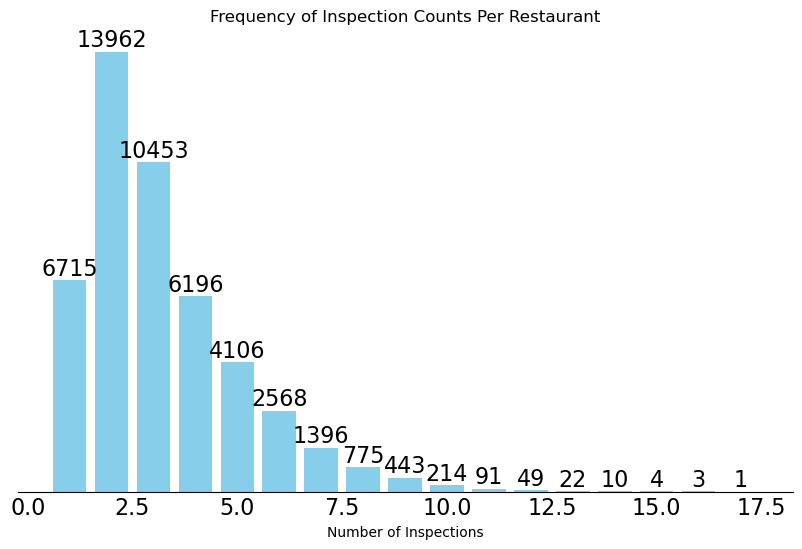

In [207]:
# Group by 'camis' and 'inspection_date' to find unique inspections
unique_inspections = inspection_df.groupby(['camis', 'inspection_date']).size().reset_index(name='counts')

# Now we will plot the value counts of these unique inspections
fig, ax = plt.subplots(figsize=(10, 6))

# Count the frequency of each inspection count
inspection_count_freq = unique_inspections['counts'].value_counts().sort_index()

# Plotting the histogram/bar chart
ax.bar(inspection_count_freq.index, inspection_count_freq.values, color='skyblue')

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(fontsize=16)
plt.xlabel('Number of Inspections')
plt.ylabel('Frequency')
plt.title('Frequency of Inspection Counts Per Restaurant')

# Adding values on top of bars
for index, value in inspection_count_freq.items():
    ax.text(index, value, str(value), ha='center', va='bottom', fontsize=16)

plt.show()


In [197]:
unique_df = inspection_df.drop_duplicates(subset=['camis', 'inspection_date']).copy()
# Convert the 'inspection_date' column to datetime if it's not already
# unique_df['inspection_date'] = pd.to_datetime(unique_df['inspection_date'])

# Extract the year from the 'inspection_date' column
unique_df['inspection_year'] = unique_df['inspection_date'].dt.year

# Count the number of inspections per year
inspections_per_year = unique_df['inspection_year'].value_counts().reset_index()
inspections_per_year.columns = ['Year', 'Inspection Count']
inspections_per_year.sort_values(by='Year', ascending=False)

,Year,Inspection Count
1,2023,17262
0,2022,20655
2,2021,3852
3,2020,2117
4,2019,2086
5,2018,525
6,2017,382
7,2016,123
8,2015,6


In [198]:
# Filter inspections older than 2019 (2018 and earlier)
older_than_2019 = inspection_df[inspection_df['inspection_date'].dt.year <= 2018]

# Display the filtered DataFrame
older_than_2019

,camis,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,cuisine_description,action,score,inspection_type,violation_code,violation_description,violation_summary
19,50037025,IG NIGHT,Queens,13135,FOWLER AVE,11355,7183587666,2018-06-09,Not Critical,2023-12-17T06:00:11.000,40.751835,-73.832927,407,20,84900,4583689,-2147483648,QN22,Chinese,Violations were cited in the following area(s).,21,Cycle Inspection / Initial Inspection,09B,Thawing procedures improper.,Improper thawing procedures
142,50018090,BLVD WINE BAR,Queens,4720,CENTER BLVD,11109,7184408520,2018-06-27,Critical,2023-12-17T06:00:11.000,40.745608,-73.957162,402,26,100,4000000,-2147483648,QN31,American,Violations were cited in the following area(s).,12,Cycle Inspection / Re-inspection,02B,Hot food item not held at or above 140º F.,TCS food not held at 140°F
322,41401794,CITI FIELD NEW YORK METS HOME CLUBHOUSE,Queens,12301,ROOSEVELT AVENUE,11368,7185958100,2017-06-13,Not Applicable,2023-12-17T06:00:11.000,40.754696,-73.845397,481,21,38302,4536844,-2147483648,QN99,American,No violations were recorded at the time of thi...,0,Cycle Inspection / Initial Inspection,none,No violations were recorded,NaN
331,50040583,AMAZURA,Queens,9112,144TH PL,11435,7182986760,2018-07-20,Not Applicable,2023-12-17T06:00:13.000,40.700543,-73.810086,412,24,21200,4213861,-2147483648,QN61,Bottled Beverages,No violations were recorded at the time of thi...,0,Inter-Agency Task Force / Initial Inspection,none,No violations were recorded,NaN
400,40364858,DOUGLASTON CLUB,Queens,600,WEST DRIVE,11363,7182293900,2018-10-25,Not Critical,2023-12-17T06:00:11.000,40.776330,-73.752835,411,19,148300,4168135,-2147483648,QN45,American,Violations were cited in the following area(s).,11,Cycle Inspection / Initial Inspection,08A,Facility not vermin proof. Harborage or condit...,"Pest harborage, signs of pests."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203815,41190515,EL RANCHO LOS COMPADRES,Manhattan,110,SHERMAN AVENUE,10034,2125691199,2018-06-23,Not Critical,2023-12-17T06:00:11.000,40.863945,-73.925017,112,10,29100,1064814,1022240041,MN01,Latin American,Violations were cited in the following area(s).,42,Cycle Inspection / Initial Inspection,08B,Covered garbage receptacle not provided or ina...,"Receptacles not pest/water resistant, uncovered."
203872,40933757,THE WORLD BAR,Manhattan,845,UNITED NATIONS PLAZA,10017,2129359361,2018-05-10,Critical,2023-12-17T06:00:11.000,40.752072,-73.967469,106,4,9000,1038909,1013407501,MN19,American,Violations were cited in the following area(s).,32,Cycle Inspection / Initial Inspection,06D,"Food contact surface not properly washed, rins...",Surface not sanitized when required.
203934,50045802,CAFE ISTANBUL,Queens,2547,STEINWAY ST,11103,6467325053,2018-08-22,Critical,2023-12-17T06:00:11.000,40.767543,-73.912007,401,22,14300,4011429,-2147483648,QN70,Middle Eastern,Violations were cited in the following area(s).,30,Cycle Inspection / Initial Inspection,02G,Cold food item held above 41º F (smoked fish a...,TCS food not held at 41°F.
204241,41583431,BODEGA NEGRA,Manhattan,355,WEST 16 STREET,10011,2122292336,2017-04-12,Not Critical,2023-12-17T06:00:11.000,40.741726,-74.003082,104,3,8300,1088885,1007407502,MN13,Mexican,Violations were cited in the following area(s).,11,Cycle Inspection / Initial Inspection,08A,Facility not vermin proof. Harborage or condit...,"Pest harborage, signs of pests."


In [124]:
# Convert 'inspection_date' to datetime if it's not already
inspection_df['inspection_date'] = pd.to_datetime(inspection_df['inspection_date'])

# Get the first inspection date for each restaurant
first_inspection_per_restaurant = inspection_df.groupby('camis')['inspection_date'].min()

# Calculate the age of each restaurant by subtracting the first inspection date from the current date
restaurant_ages = (pd.to_datetime('today') - first_inspection_per_restaurant).dt.days // 365

# Count the number of restaurants by age
restaurants_by_age = restaurant_ages.value_counts().sort_index()
restaurants_by_age.sum()


19965

In [93]:
# Get the first inspection date for each restaurant
first_inspection_per_restaurant = inspection_df.groupby('camis')['inspection_date'].min()

# Find the oldest restaurant by getting the earliest date in the series
oldest_restaurant_date = first_inspection_per_restaurant.min()

# Get the year of the oldest restaurant
oldest_restaurant_year = oldest_restaurant_date.year
oldest_restaurant_year

2015

In [89]:
inspection_df.camis.nunique()

19857

In [84]:
# Step 1: Group by borough and restaurant, then count unique inspections for each restaurant
inspections_per_restaurant_per_boro = inspection_df.groupby(['boro', 'camis'])['inspection_date'].nunique()

# Step 2: Calculate the average number of inspections per restaurant for each borough
average_inspections_per_restaurant_per_boro = inspections_per_restaurant_per_boro.groupby('boro').mean()

print(average_inspections_per_restaurant_per_boro)


boro
Bronx            2.348234
Brooklyn         2.442772
Manhattan        2.293863
Queens           2.370247
Staten Island    2.384615
dtype: float64


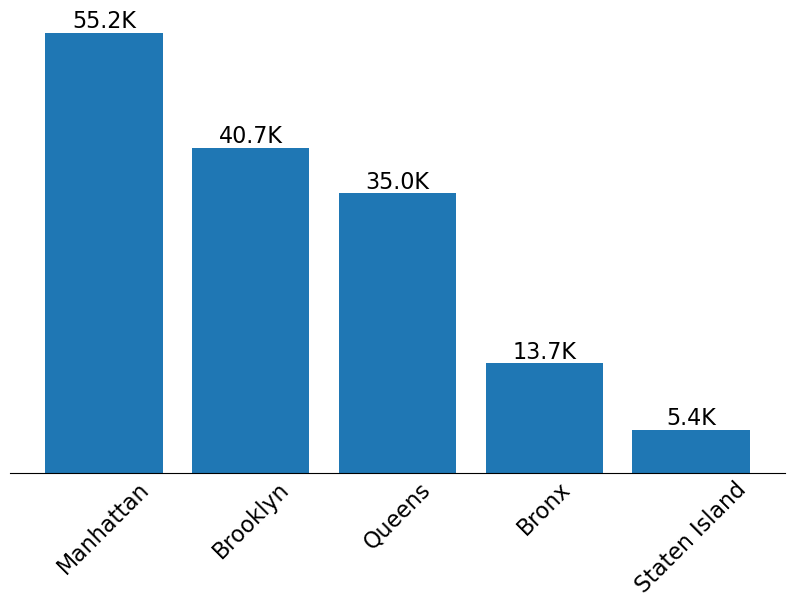

In [71]:
borough_counts = inspection_df['boro'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(borough_counts.index, borough_counts.values)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

for bar in bars:
    height = bar.get_height()
    if height > 1000:
        text_label = f'{height / 1000:.1f}K'
    else:
        text_label = str(int(round(height / 10) * 10))
    
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, text_label,
            ha='center', va='bottom', fontsize=16)

plt.show()


In [11]:
# Calculate unique inspections by grouping by 'camis' and 'inspection_date'
unique_inspections = inspection_df.groupby(['camis', 'inspection_date']).size().reset_index(name='inspection_count')

# Get the distribution of boroughs for these unique inspections
borough_counts = unique_inspections['boro'].value_counts()

plt.figure(figsize=(10, 6))
ax = borough_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Restaurants by Borough for Unique Inspections')
plt.xticks(rotation=45)

# Display borough names on the bars
ax.set_xticklabels(borough_counts.index, rotation=45)

# Remove Y-axis
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', left=False, labelleft=False)

# Remove the square around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the horizontal X line
ax.spines['bottom'].set_visible(False)

# Remove X ticks
plt.xticks([])

# Remove X and Y labels
plt.xlabel('')
plt.ylabel('')

# Add values at the top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

KeyError: 'boro'

In [12]:
unique_inspections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46830 entries, 0 to 46829
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   camis             46830 non-null  int64 
 1   inspection_date   46830 non-null  object
 2   inspection_count  46830 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
